<span style="font-family:Trebuchet MS; font-size:2em;">Project 3 | NB4: Pre-Processing and Modeling</span>

Riley Robertson | Reddit Classification Project | Market Research: Sports Fans in the U.S. and England

# Imports and Setup

## Module Imports

In [54]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom
import utilities.densmore as dns


# Modeling
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

# Plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

---

## Reading in CSV with clean data

In [2]:
df = pd.read_csv('../data/2_clean/reddit_posts_clean.csv')

In [4]:
# df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12416 entries, 0 to 12415
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    12416 non-null  object
 1   target       12416 non-null  int64 
 2   author       12416 non-null  object
 3   score        12416 non-null  int64 
 4   comments     12416 non-null  int64 
 5   tag          12416 non-null  object
 6   index        12416 non-null  int64 
 7   created_utc  12416 non-null  int64 
 8   date         12416 non-null  object
 9   time         12416 non-null  object
 10  title        12416 non-null  object
 11  post         12372 non-null  object
 12  alltext      12416 non-null  object
dtypes: int64(5), object(8)
memory usage: 1.2+ MB


## Creating a custom color map for plotting

In order to create plots that will fit well in my project presentation, I created a custom color-map that I could apply to any plots I generate during my model evaluation. I could then save those plots to a .png to import into my slide deck.

To make it, I used code that I in a stackoverflow thread here:  
    https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale  
To get it working, I just had to install 'colour-0.1.5' using `pip install colour` in terminal.

In [ ]:
def make_colormap(colors_list): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_map = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors_list])
    plt.figure(figsize = (8,2))
    plt.imshow([list(np.arange(0, len(colors_list) , 0.1))] , interpolation='nearest', origin='lower', cmap= color_ramp)
    plt.xticks([])
    plt.yticks([])
    return color_map

custom_cmap = make_colormap(['#f3ffd1','#91c603']) 

| <span style="font-family:Trebuchet MS; font-size:2em;">English Premier League</span>     | ┃ | <span style="font-family:Trebuchet MS; font-size:2em;">National Football League</span> | 
|---------------------:|---:|:------------------|

# Pre-Processing

In [55]:
# 1st iteration models
# df_m = df[['subreddit', 'target', 'score', 'comments', 'tag', 'alltext']] # First Version - All Columns

# 2nd iteration models
df_m = df[['subreddit', 'target', 'alltext']]

## Get Dummies

I initially began my preprocessing by creating dummy columns for the tag columns, but ultimately decided to drop all columns except for my 'alltext' column to feed to my models. 

I realized after the first iterations of each of my models that several steps I took during cleaning made it significantly easier for the model to classify the posts. For example, I removed all nfl posts with tags (flair-text) from the data and filled the remaining posts with the string 'none'. This was one of the most important features to my 1st models because of something I had done. 

I came back and removed that column, as well as the score and comments columns. I wanted to see how the model would do if we only gave it the text. 

And they both still performed very well. Only dropping in accuracy by about ~1% each.

In [7]:
# df_m_dums = pd.get_dummies(df_m['tag'], drop_first=True)
# df_m = pd.concat([df_m, df_m_dums], axis=1)
# df_m.drop(columns=['tag'], inplace=True)
# df_m.head(2)

I decided to keep the code here in case I need to come back to it for any reason.

## Train/Test Split

I split up my data using train/test split so I could train my models on one segment and test on the other. This split will serve any models I do below. 

In [11]:
X = df_m.drop(columns=['subreddit', 'target'])
y = df_m['target']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=74, stratify=y)

In [13]:
X_train.head()

,alltext
4942,Eden Hazard mocks Raheem Sterling (VIDEO) [Ede...
10922,How come they dont construct and then sell sea...
12078,Will Roger Goodell still be NFL Commissioner a...
10896,To people watching NO@CAR or ARI@GB in Week 17...
4571,help me are there a lot of jewish arsenal fans...


In [53]:
X_test.head()

,alltext
0,People talked about the wrong thing on the cal...
1,Who is the best player to play on more than th...
2,What surprise team could “win” the Trevor Lawr...
3,"🇬🇧Mourinho again overtook Karma, Pochettino ou..."
4,What do you think Drew Bledsoes career would h...


## Vectorizing with TFIDF

### Stop Words

I used the english stop words list from the text module and assigned it to a variable so I could use in vectorization. I also set it up this way so that I could add custom stop words if decide there's a need to do so.

In [15]:
# add_stop_words = []
stp_wds = text.ENGLISH_STOP_WORDS #.union(add_stop_words) # uncomment list and .union() to add stop words

Other than removing stopwords, there are other ways we can prepare text for modeling, like stemming and lemmatization. I decided to see how my models came out without those transformations to the text and the results were excellent (more on the model outcomes later).

### TF-IDF

For vecorization, I wanted to go beyond simple word counts. I decided to use TFIDF for the additional predictive power it gains by weighting words according to their importance in a particular post relative to the other posts in the DataFrame. 

In [16]:
tvec = TfidfVectorizer(stop_words=stp_wds)                # instantiate vectorizer

X_train_tvec = tvec.fit_transform(X_train['alltext'])     # fit/transform X_train
X_test_tvec = tvec.transform(X_test['alltext'])           # transform X_test

After the fit/transform process, our vectorized data are in a format optimized for storage and not for analysis. So it has to be converted to a dense matrix and then into a pandas DataFrame before we can take our next steps. 

In [17]:
type(X_train_tvec)       # sparse matrix

scipy.sparse.csr.csr_matrix

In [18]:
X_train_tvec.todense()   # dense matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
X_train_df = pd.DataFrame(X_train_tvec.todense(), columns=tvec.get_feature_names())
# X_train_df.head()

In [20]:
X_test_df = pd.DataFrame(X_test_tvec.todense(), columns=tvec.get_feature_names())
# X_test_df.head()

Once they're converted, I reset their indexes of the DataFrames to make sure things were clean moving forward and then concatenated the vecorized columns to the split DataFrames (Train and Test).

In [21]:
X_train_df.reset_index(drop=True, inplace=True)      # reset train_df index after transform
X_train.reset_index(drop=True, inplace=True)         # reset original X_train to match for concat

X_test.reset_index(drop=True, inplace=True)          # reset test_df index after transform
X_test_df.reset_index(drop=True, inplace = True)     # reset original X_test to match for concat

In [59]:
X_train_all = pd.concat([X_train, X_train_df],axis = 1)    # concat train token columns with other features
# X_train_all.head()

In [23]:
X_train_all.shape

(9312, 27619)

In [24]:
X_test_all = pd.concat([X_test, X_test_df],axis = 1)       # concat test token columns with other features
# X_test_all.head()

# Modeling

## Baseline Model

In [25]:
y_test.value_counts(normalize=True)

1    0.562178
0    0.437822
Name: target, dtype: float64

The cleaned dataset contains about 56% NFL posts and 44% EPL posts. This is our baseline model. We hope (and at this point fully expect) that our model will far exceed this level of accuracy. 

## Logistic Regression

I started with Logistic Regression because our primary goal is to identify which words are the most prominant and important within these subreddit communities. This was the emphasis of OverArmor's requests.

With LogReg, we can interpret the coefficients for each word to determine it's impact on the likliness of a post to be categorized in the majority class. 

### X, y setup

In [26]:
X_train_mod = X_train_all.drop(columns=['alltext'])
y_train_mod = y_train
X_test_mod = X_test_all.drop(columns=['alltext'])
y_test_mod = y_test

### Custom quickmodel function

In [56]:
# dns.quickmod_logregsa_nlp(X_train=X_train_mod, y_train=y_train_mod, 
#                                X_test=X_test_mod, y_test=y_test_mod,
#                                alist=[.15, .1525, .155, .1575, .16], 
#                                penalty='l1', 
#                                random_state=74
#                                )

<span style="font-family:Trebuchet MS; display:block; text-align:center; font-size:2em;">Testing Values for 𝛼</span>

| alpha     | C           | Train Acc.| Test Acc.   |
|:----------|:------------|:----------|:------------|
|   0.15    |   6.6667    |   1       | 0.9745      |
|**0.1525** | **6.5574**  | **1**     |**0.9749**   |
| 0.155     | 6.4516      | 1         | 0.9745      |
| 0.16      | 6.25        | 1         | 0.9742      | 


^ These values are the test accuracy scores after I removed excess columns. The best score here is the .975 score using an alpha of .1525.

<span style='font-family:Trebuchet MS; display:block; text-align:center; font-size:2em;'>Testing Values for 𝛼</span>
    
`|         Batch 1          |          Batch 2           |           Batch 3           |         Batch 4         |`
    
| alpha     | C           | Train Acc.| Test Acc.     |┃| alpha     | C           | Train Acc.| Test Acc.   |┃| alpha       | C           | Train Acc.| Test Acc.     |┃| alpha     | C           | Train Acc.| Test Acc.   |
    |:----------|:------------|:----------|:--------------| |:----------|:------------|:----------|:------------| |:----------|:------------|:----------|:--------------| |:----------|:------------|:----------|:------------|
    | **0.1**   | **10**      | **1**     | **0.9872**    |┃| 0.05      | 20          | 1         | 0.9875      |┃| 0.04        | 25          | 1         | 0.9869        |┃| **0.15**  | **6.6667**  | **1**     | **0.9885**  |
    | 0.2       | 5           | 1         | 0.9860        |┃| 0.8       | 1.25        | 1         | 0.9796      |┃| 0.06        | 16.6667     | 1         | 0.9879        |┃| 0.1525    | 6.5574      | 1         | 0.9879      |
    | 0.3       | 3.3333      | 1         | 0.9866        |┃| 0.12      | 8.3333      | 1         | 0.9869      |┃| 0.14        | 7.1428      | 1         | 0.9860        |┃| 0.155     | 6.4516      | 1         | 0.9888      |
    | 0.4       | 2.5         | 1         | 0.9818        |┃| **0.15**  | **6.6667**  | **1**     | **0.9885**  |┃| **0.16**    | **6.25**    | **1**     | **0.9888**    |┃| **0.16**  | **6.25**    | **1**     | **0.9888**  | 

^ This table of scores came from my first tests with the quickmodel function. Once I realized that my cleaning strategies had skewed the model, I came back and ran one batch using the best values from earlier tests (batch 4).

### Using best value for alpha

In [28]:
sc = StandardScaler(with_mean=False)

Z_train = sc.fit_transform(X_train_mod)
Z_test = sc.transform(X_test_mod)

logreg = LogisticRegression(penalty='l1', C=(1/.155), solver='liblinear', random_state=74)

logreg.fit(Z_train, y_train_mod)

LogisticRegression(C=6.451612903225807, penalty='l1', random_state=74,
                   solver='liblinear')

### Accuracy

In [29]:
logreg.score(Z_train, y_train_mod)

1.0

In [30]:
logreg.score(Z_test, y_test_mod)

0.9745489690721649

The accuracy scores for the Logistic regression model are looking really good. There's a bit of overfitting (the training score is slightly higher than the test score), but at only 2.5% difference, the amount is not far from negligible. 97% accuracy blows our baseline model  out of the water. Rather than simply guessing the majority class for every post (only 56% accuracy), our model only mis-classified about 2.5% of the posts based on text alone.

I want to see how a Random Forest model will do, but this is in great shape and can serve as a deliverable model if others fall short. This will fullfill the Second of Overarmor's requests.

### Predictions and Confusion Matrix

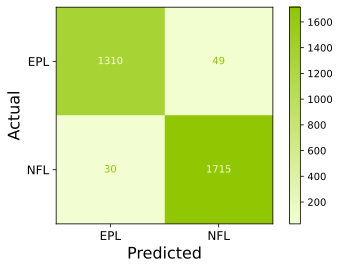

In [60]:
logreg_preds = logreg.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel()

plot_confusion_matrix(logreg, Z_test, y_test, values_format='d', cmap=custom_cmap, display_labels=['EPL', 'NFL']);

plt.xlabel('Predicted', size = 16)
plt.xticks(size = 12)

plt.ylabel('Actual', size = 16)
plt.yticks(size = 12)

plt.savefig('../visualizations/logistic_regression_conf_mtrx.png', dpi=300, transparent=True)

Our confusion matrix shows that we only misidentified 79 posts. Correctly classifying 3025.

In [32]:
plt.savefig

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [33]:
print(f'  True Neg: {tn}    False Pos: {fp}')
print(f' False Neg: {fn}       True Pos: {tp}')

  True Neg: 1310    False Pos: 49
 False Neg: 30       True Pos: 1715


### Evaluation - Exponentiated Coefficients

In [34]:
logreg_coefs_exp = list(zip(X_train_mod.columns, (list(np.exp(logreg.coef_)[0]))))

In [35]:
# pd.DataFrame(logreg_coefs_exp, columns=['Feature Name', 'Odds']).sort_values(by=['Odds'], ascending = False)[161:201]

In [36]:
# pd.DataFrame(logreg_coefs_exp, columns=['Feature Name', 'Odds']).sort_values(by=['Odds'], ascending = True)[161:201]

**Top Words**

With the logistic regression model, I needed to evaluate the exponentiated coefficients for each word. for the sake of our client, I also wanted to build a list of the most relevant words I built a list of the top 200 coefficients for each subreddit and exported it to .csv so I can give it to the client (located in '../data/3_output/'). All of that data came from my first models, though. With more time, I could come back and recollect the top words from the new LogReg model and refurnish the list. Based on what I know about the data at this point, there will certainly be changes, but they likely won't be massive. 

To interpret the exponentiated coefficients, we can say that the additional inclusion of a particular token means that classification as the majority class is [odds] times as likely.

One other thing I changed between previous models and this one is that I had accidentally set the minority class as 1. So the high numbers below are connected to classification as being from the PremierLeague Subreddit. While new coefficients would show the reverse.

<span style="font-family:Trebuchet MS; display:block; text-align:center; font-size:2em;">Token Importance</span>
<span style="font-family:Trebuchet MS; display:block; text-align:center; font-size:em;">Token Importance</span>

|| <span style="font-family:Trebuchet MS; font-size:2em;">English Premier League</span>|  | <span style="font-family:Trebuchet MS; font-size:2em;">National Football League</span> | |
|---|---------------------:|---:|:------------------|---|



| Odds     | EPL Tokens (21-40)      | ┃ | Odds     | EPL Tokens (1-20)    | ┃ | NFL Tokens (1-20) | Odds     | ┃ | NFL Tokens (21-40) | Odds     |
|---------:|------------------------:|:-:|---------:|---------------------:|:-:|:------------------|:---------|:-:|:------------------|:---------|
| 1.449 | clubs                   | ┃ | 9.527 | Discussion           | ┃ | nfl               | 0.103 | ┃ | division          | 0.786 |
| 1.44  | everton                 | ┃ | 5.964 | premier              | ┃ | comments          | 0.406 | ┃ | college           | 0.793 |
| 1.428 | goals                   | ┃ | 5.710 | Question             | ┃ | qb                | 0.485 | ┃ | rookie            | 0.797 |
| 1.406 |       Manchester United | ┃ | 2.853   | liverpool            | ┃ | bowl              | 0.573 | ┃ | coaches           | 0.797 |
| 1.401 | fixtures                | ┃ | 2.770 | pl                   | ┃ | draft             | 0.583 | ┃ | playoffs          | 0.804 |
| 1.381 | goal                    | ┃ | 2.330 | club                 | ┃ | field             | 0.635  | ┃ | rodgers           | 0.80  |
| 1.380 | matches                 | ┃ | 2.291 | league               | ┃ | patriots          | 0.652 | ┃ | conference        | 0.816 |
| 1.365 | manchester              | ┃ | 2.274 | Premier League       | ┃ | offense           | 0.656 | ┃ | superbowl         | 0.821 |
| 1.365 |       Liverpool         | ┃ | 2.154 | arsenal              | ┃ | yards             | 0.673 | ┃ | running           | 0.823 |
| 1.340 | wolves                  | ┃ | 2.131 | epl                  | ┃ | brady             | 0.682 | ┃ | qbs               | 0.824 |
| 1.337  | prem                    | ┃ | 2.081  | chelsea              | ┃ | playoff           | 0.693 | ┃ | pff               | 0.829 |
| 1.331 | cup                     | ┃ | 1.841 | var                  | ┃ | none              | 0.701 | ┃ | practice          | 0.830 |
| 1.320 | southampton             | ┃ | 1.702 | united               | ┃ | cowboys           | 0.734 | ┃ | guy               | 0.830 |
| 1.315  | mourinho                | ┃ | 1.672 | match                | ┃ | franchise         | 0.746 | ┃ | nfc               | 0.834 |
| 1.315 | newcastle               | ┃ | 1.655 | poll                 | ┃ | eagles            | 0.752 | ┃ | brown             | 0.834 |
| 1.290 | transfer                | ┃ | 1.642  | spurs                | ┃ | browns            | 0.753 | ┃ | yard              | 0.835 |
| 1.280 | manager                 | ┃ | 1.629 | tottenham            | ┃ | ravens            | 0.768 | ┃ | trade             | 0.837 |
| 1.277 | london                  | ┃ | 1.571 | city                 | ┃ | quarterback       | 0.771 | ┃ | pass              | 0.840 |
| 1.272 | leicester               | ┃ | 1.532 | english              | ┃ | jets              | 0.774 | ┃ | years             | 0.841 |
| 1.248 | brighton                | ┃ | 1.469 | News                 | ┃ | offensive         | 0.774 | ┃ | like              | 0.841 |

| <span style="font-family:Trebuchet MS; font-size:2em;">English Premier League</span>     | ┃ | <span style="font-family:Trebuchet MS; font-size:2em;">National Football League</span> | 
|---------------------:|---:|:------------------|

| Odds     | EPL Tokens (61-80)    | ┃ | Odds     | EPL Tokens (41-60)      | ┃ | NFL Tokens (41-60) | Odds     | ┃ | NFL Tokens (61-80) | Odds     |
|---------:|------------------------:|:-:|---------:|---------------------:|:-:|:------------------|:---------|:-:|:------------------|:---------|
| 1.196975 | premierleague         | ┃ | 1.247207 | palace                  | ┃ | td                 | 0.842231 | ┃ | year               | 0.859388 |
| 1.196412 | leeds                 | ┃ | 1.246749 | offside                 | ┃ | giants             | 0.842783 | ┃ | falcons            | 0.859973 |
| 1.195304 | Chelsea               | ┃ | 1.244287 | madrid                  | ┃ | offseason          | 0.843461 | ┃ | sacks              | 0.86044  |
| 1.191963 | join                  | ┃ | 1.239036 | villa                   | ┃ | chiefs             | 0.844952 | ┃ | receiver           | 0.860556 |
| 1.185141 | sky                   | ┃ | 1.238473 | american                | ┃ | bay                | 0.844984 | ┃ | dude               | 0.861166 |
| 1.184474 | burnley               | ┃ | 1.236565 | hello                   | ┃ | roster             | 0.845317 | ┃ | broncos            | 0.861406 |
| 1.183534 | ham                   | ┃ | 1.227556 | pogba                   | ┃ | 16                 | 0.845399 | ┃ | plays              | 0.862848 |
| 1.174342 | finish                | ┃ | 1.219523 | today                   | ┃ | steelers           | 0.846241 | ┃ | cap                | 0.863694 |
| 1.17416  | Manchester City       | ┃ | 1.217903 | sterling                | ┃ | rams               | 0.846504 | ┃ | cardinals          | 0.863955 |
| 1.173772 | stream                | ┃ | 1.215974 | nbc                     | ┃ | wr                 | 0.847066 | ┃ | coach              | 0.866043 |
| 1.168381 | nbcsn                 | ┃ | 1.215363 | salah                   | ┃ | williams           | 0.847163 | ┃ | contract           | 0.869072 |
| 1.167137 | title                 | ┃ | 1.214193 | world                   | ┃ | bears              | 0.84778  | ┃ | lions              | 0.870203 |
| 1.166319 | watford               | ┃ | 1.209385 | Tottenham Hotspur       | ┃ | rules              | 0.84848  | ┃ | hall               | 0.87065  |
| 1.165636 | bruyne                | ┃ | 1.206445 | bissaka                 | ┃ | 12                 | 0.853288 | ┃ | decided            | 0.872295 |
| 1.164696 | fantasy               | ┃ | 1.206409 | pitch                   | ┃ | night              | 0.853389 | ┃ | picks              | 0.872544 |
| 1.162007 | signings              | ┃ | 1.204813 | thanks                  | ┃ | packers            | 0.854285 | ┃ | calls              | 0.872669 |
| 1.161203 | Leeds United          | ┃ | 1.203586 | soccer                  | ┃ | football           | 0.855693 | ┃ | sb                 | 0.872748 |
| 1.15957  | podcasts              | ┃ | 1.20307  | streams                 | ┃ | numbers            | 0.856211 | ┃ | smith              | 0.873245 |
| 1.158943 | ozil                  | ┃ | 1.201184 | x200b                   | ┃ | defense            | 0.856393 | ┃ | pats               | 0.873918 |
| 1.158394 | subtitles             | ┃ | 1.199226 | relegation              | ┃ | chargers           | 0.857366 | ┃ | te                 | 0.875945 |

## Random Forest

Lastly, I tried out the Random forest model and it ultimately performed very similarly to the Logistic Regression.

### Setup

In [37]:
rfc = RandomForestClassifier()

In [38]:
params = {
    'n_estimators': [100, 300, 600],
    'max_depth': [5, 40],
    'max_features': [500, 1000, 3000]
}

### Gridsearch and Fit

I ran a gridsearch to find the best parameters and fit a model using those parameters. 

In [39]:
rfc_gs = GridSearchCV(rfc, params, cv=3, verbose=1, n_jobs=-2)

In [40]:
rfc_gs.fit(X_train_mod, y_train_mod)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-2)]: Done  54 out of  54 | elapsed: 38.6min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [5, 40],
                         'max_features': [500, 1000, 3000],
                         'n_estimators': [100, 300, 600]},
             verbose=1)

In [41]:
# checks
X_train_mod.shape, y_train_mod.shape

((9312, 27618), (9312,))

### Results

In [42]:
rfc_gs.best_params_

{'max_depth': 40, 'max_features': 500, 'n_estimators': 300}

In [43]:
rfc_gs.best_score_

0.9771262886597939

The Accuracy score here is slightly higher than 

### Confusion Matrix

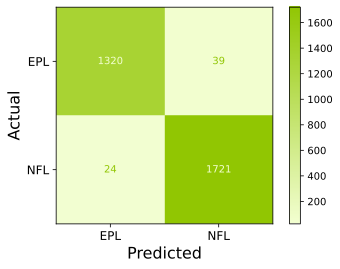

In [61]:
random_forest_preds = rfc_gs.predict(X_test_mod)

tn, fp, fn, tp = confusion_matrix(y_test_mod, random_forest_preds).ravel()

plot_confusion_matrix(rfc_gs, X_test_mod, y_test_mod, values_format='d', cmap=custom_cmap, display_labels=['EPL', 'NFL']);

plt.xlabel('Predicted', size = 16)
plt.xticks(size = 12)

plt.ylabel('Actual', size = 16)
plt.yticks(size = 12)

plt.savefig('../visualizations/random_forest_conf_mtrx.png', dpi=300, transparent=True)

Our confusion matrix shows similar (but slightly better) results than our matrix for the logistic regression model - The Random Forest only misclassified 63 posts. Correctly classifying 3041.

With an accuracy of 97.7% this is the model we'll use in our work for OverArmor give to them as a tool they can use in the future.

In [45]:
print(f'  True Neg: {tn}    False Pos: {fp}')
print(f' False Neg: {fn}       True Pos: {tp}')

  True Neg: 1320    False Pos: 39
 False Neg: 24       True Pos: 1721


In [46]:
# .best_estimator_.feature_importance()

In [47]:
d = {'Column Name':X_train_mod.columns,'Feature Importance':rfc_gs.best_estimator_.feature_importances_}
fi = pd.DataFrame(d)
# fi.head()
rfc_fi = fi.sort_values(by=['Feature Importance'], ascending = False).head(50)

Here are the Feature importances for the Random Forest model. They are different than our coefficients. Rather than a value that tells us an increase in liklihood. The FI metric is a measure of relevance to the models ability to classify the posts.

This is another list I can provide the client as they study words used by each subreddit.

With more time, I would dive into all of these lists much more deeply. Filtering out the most common, comparing the words that are unique and shared, identifying what categories the words fall into (like player names, team names, game vocabulary, or categories of speech unrelated to the game itself).  

In [62]:
rfc_fi.to_csv('../data/3_output/random_forest-feature_importance.csv', index=False)